In [1]:
import sys
sys.path.append('../')

from MRIsegm.utils import get_slices, get_slices_info, get_rois, explore_slices, explore_roi, mask_slices

In [2]:
src = '/Users/giuseppefilitto/Pazienti_anonym_sorted/'
patient = 'BO56/'
dir_path =  src + patient + 'T2'

slices = get_slices(dir_path=dir_path, uint8=False)
get_slices_info(slices=slices)

The image object has the following dimensions: depth:24, height:512, width:512


In [3]:
roi_path = src + patient + 'T2ROI'

rois = get_rois(roi_path=roi_path) 
positions = [rois[i].get('position') - 1 for i in range(len(rois))]

# set(positions) to have unique values
print(f"number of masks = {len(set(positions))}")

number of masks = 24


Text(0.5, 1.0, 'original image')

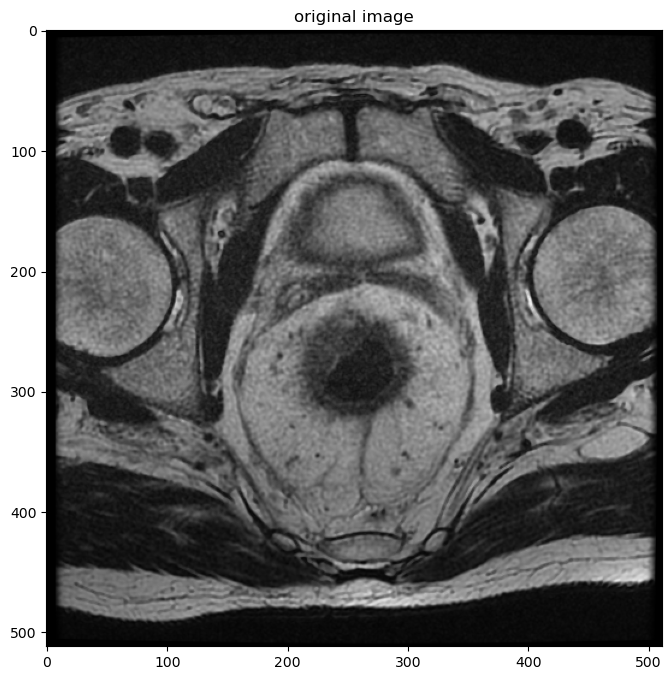

In [4]:
import matplotlib.pyplot as plt
plt.style.use('default')


layer = 9
plt.figure(figsize=(8, 8))
plt.imshow(slices[layer, ...], cmap='gray', vmin=slices.min(), vmax=slices.max())
plt.title('original image')
# plt.colorbar()

In [5]:
import cv2
layer = 9

img = slices[layer, ...]
test = cv2.normalize(img, dst=None, alpha=0, beta=1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
print('dtype:', test.dtype)
print('max:', test.max())
print('min:', test.min())


dtype: float32
max: 1.0
min: 0.0


(-0.5, 511.5, 511.5, -0.5)

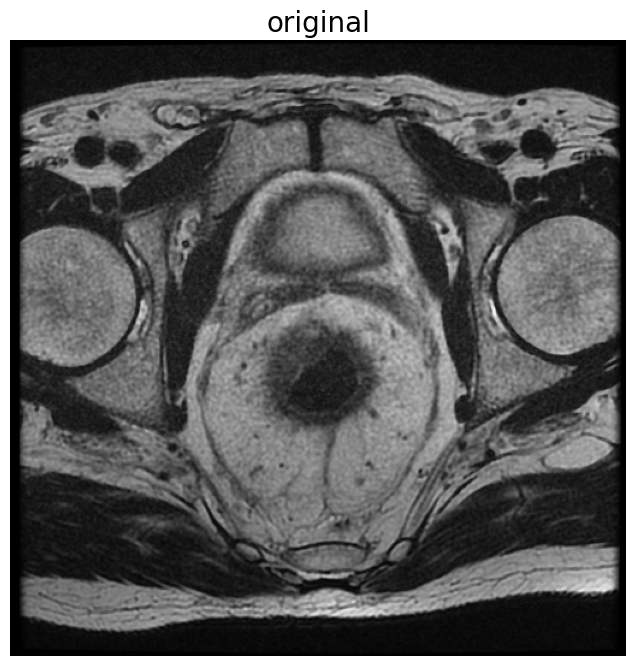

In [6]:
plt.figure(figsize=(8, 8))
plt.imshow(test, cmap='gray')
plt.title('original', fontsize=20)
plt.axis('off')
#plt.colorbar()

In [7]:
img_1 = img/img.max()

print('dtype:', img_1.dtype)
print('max:', img_1.max())
print('min:', img_1.min())

dtype: float64
max: 1.0
min: 0.0


In [8]:
diff = test - img_1

print('%.16f' % diff.mean())

-0.0000000018311292


In [9]:
y = 256
dy = y // 2

x = 256
dx = x // 2

new_img = test[(y-dy):(y+dy), (x-dx):(x+dx)]

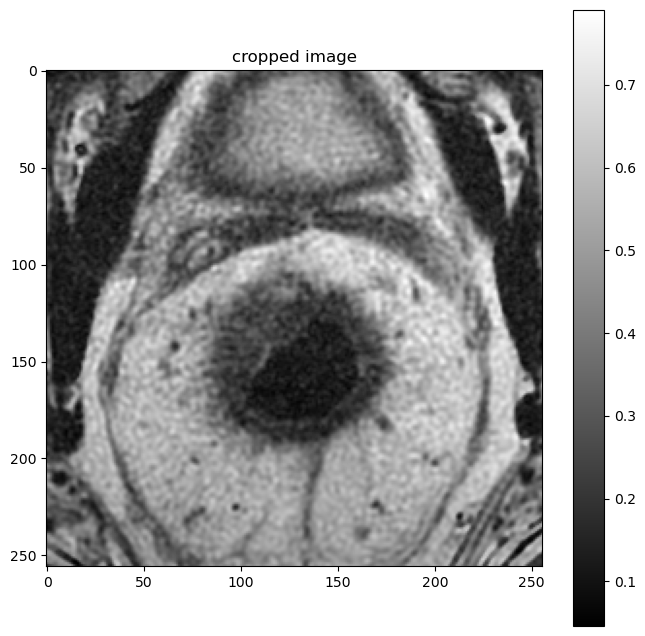

In [10]:
plt.figure(figsize=(8, 8))
plt.imshow(new_img, cmap='gray')
plt.title('cropped image')
plt.colorbar()

In [11]:
from skimage.restoration import denoise_nl_means, estimate_sigma


import numpy as np

sigma_est = np.mean(estimate_sigma(new_img))
print(f'estimated noise standard deviation = {sigma_est}')


patch_kw = dict(patch_size=5, patch_distance=6)

denoise2_fast = denoise_nl_means(new_img, h=10 * sigma_est, sigma=sigma_est,
                                 fast_mode=True, **patch_kw)


mean = denoise2_fast.mean()
std = denoise2_fast.std()

snr_deno = np.where(std == 0, 0, mean / std)

print(f'SNR after denoising: {snr_deno:0.3f}')

mean_ori = new_img.mean()
std_ori = new_img.std()

snr_ori = np.where(std == 0, 0, mean_ori / std_ori)

print(f'SNR original: {snr_ori:0.3f}')



estimated noise standard deviation = 0.004486043279284308
SNR after denoising: 2.406
SNR original: 2.347


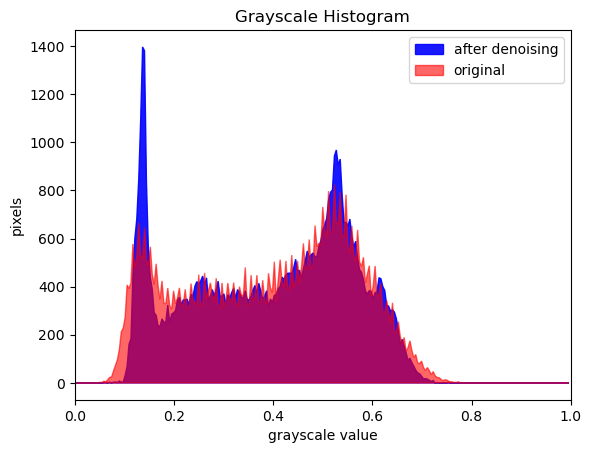

In [12]:
histogram_ori, bin_edges_ori = np.histogram(new_img, bins=256, range=(0, 1))
histogram_deno, bin_edges_deno = np.histogram(denoise2_fast, bins=256, range=(0, 1))
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim([0.0, 1.0])  # <- named arguments do not work here

plt.fill(bin_edges_deno[0:-1], histogram_deno, c='b', label='after denoising', alpha = 0.9)
plt.fill(bin_edges_ori[0:-1], histogram_ori, c='r', label = 'original', alpha = 0.6) 
plt.legend()
plt.show()

In [13]:
def gamma_correction(img, gamma=1.0):
  igamma = 1.0 / gamma
  imin, imax = img.min(), img.max()

  img_c = img.copy()
  img_c = ((img_c - imin) / (imax - imin)) ** igamma
  img_c = img_c * (imax - imin) + imin
  return img_c

In [14]:
gamma = 1.5
gamma_img = gamma_correction(denoise2_fast, gamma=gamma)

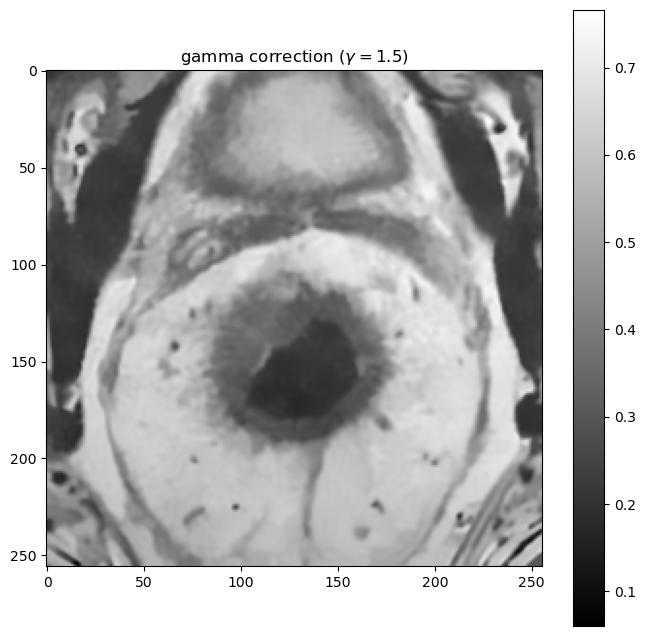

In [15]:
plt.figure(figsize=(8, 8))
plt.imshow(gamma_img, cmap='gray')
plt.title(f'gamma correction ($\gamma = {gamma}$)')
plt.colorbar()

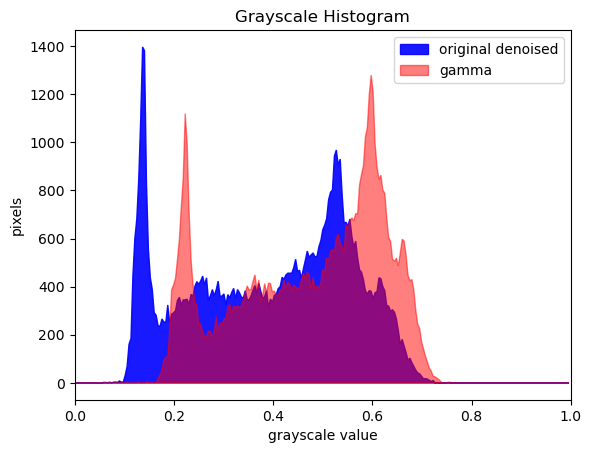

In [16]:
histogram_gamma, bin_edges_gamma = np.histogram(gamma_img, bins=256, range=(0, 1))
histogram, bin_edges = np.histogram(denoise2_fast, bins=256, range=(0, 1))
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim([0.0, 1.0])  # <- named arguments do not work here

plt.fill(bin_edges[0:-1], histogram, c='b', label='original denoised', alpha = 0.9)
plt.fill(bin_edges_gamma[0:-1], histogram_gamma, c='r', label = 'gamma', alpha = 0.5) 
plt.legend()
plt.show()

In [17]:
sigma_est = np.mean(estimate_sigma(test))
denoised_full = denoise_nl_means(test, h=10 * sigma_est, sigma=sigma_est,
                                 fast_mode=True, **patch_kw)

(-0.5, 511.5, 511.5, -0.5)

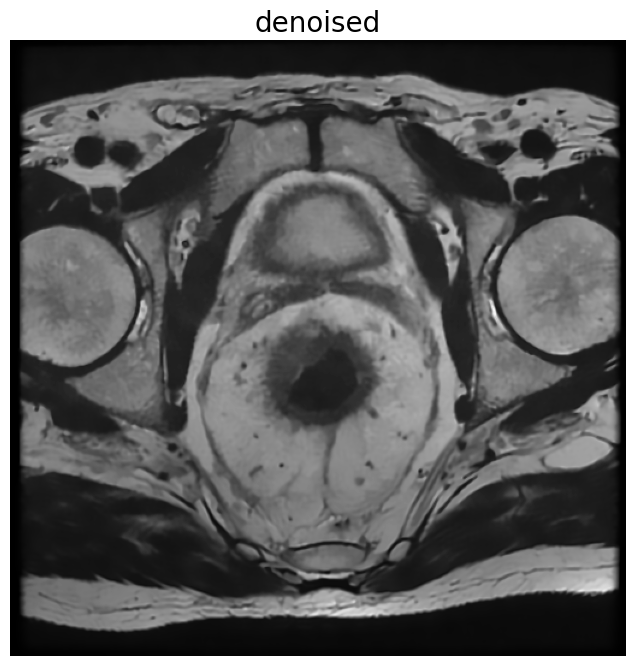

In [18]:
plt.figure(figsize=(8, 8))
plt.imshow(denoised_full, cmap='gray')
plt.title(f'denoised', fontsize=20)
plt.axis('off')
#plt.colorbar()

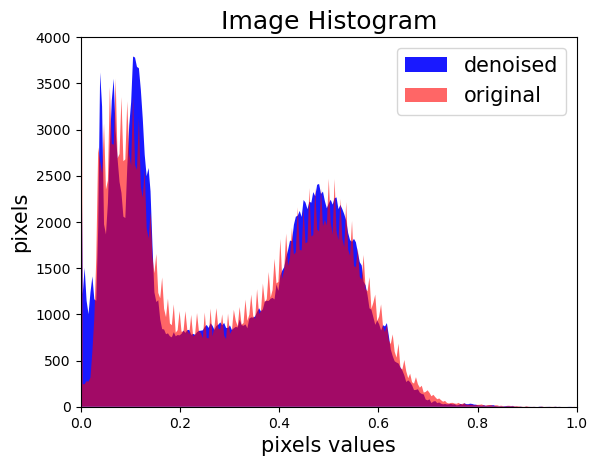

In [19]:
histogram_gamma, bin_edges_gamma = np.histogram(test, bins=256, range=(0, 1))
histogram, bin_edges = np.histogram(denoised_full, bins=256, range=(0, 1))
plt.figure()
plt.title("Image Histogram", fontsize=18)
plt.xlabel("pixels values", fontsize=15)
plt.ylabel("pixels", fontsize=15)
plt.xlim([0, 1.0])  # <- named arguments do not work here
plt.ylim([0.0, 4000])

plt.fill_between(bin_edges[0:-1], histogram, facecolor='b', label='denoised', alpha = 0.9)
plt.fill_between(bin_edges_gamma[0:-1], histogram_gamma, facecolor='r', label = 'original', alpha = 0.6) 
plt.legend(fontsize=15)
plt.show()

(-0.5, 511.5, 511.5, -0.5)

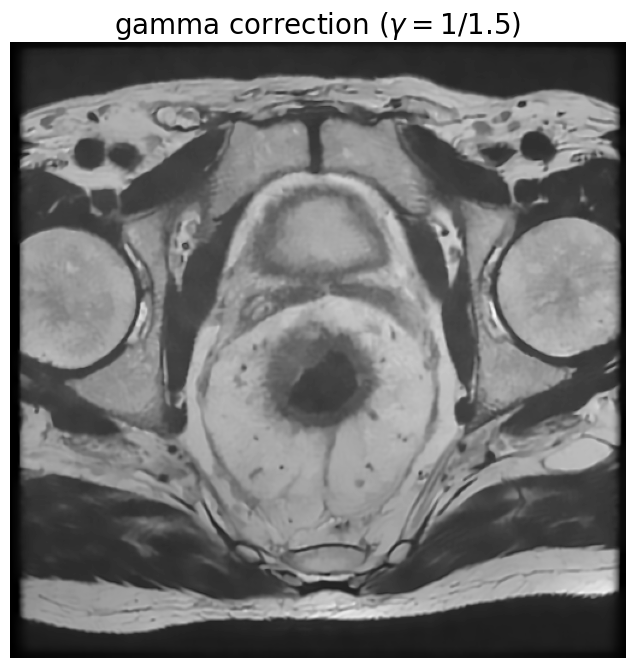

In [20]:
gamma = 1.5

gamma_full = gamma_correction(denoised_full, gamma=gamma)

plt.figure(figsize=(8, 8))
plt.imshow(gamma_full, cmap='gray')
plt.title(f'gamma correction ($\gamma = 1/{gamma}$)', fontsize=20)
plt.axis('off')

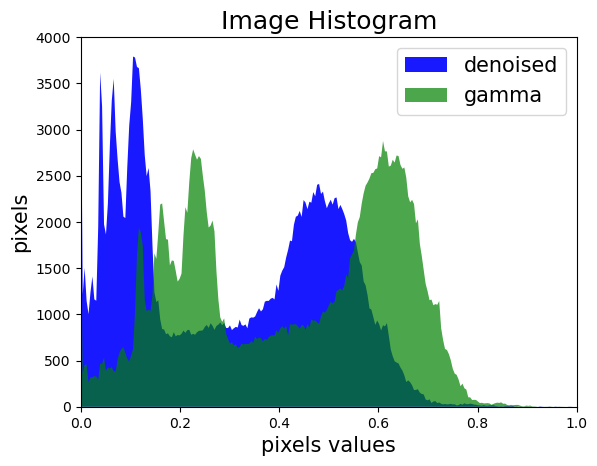

In [21]:
histogram_gamma, bin_edges_gamma = np.histogram(gamma_full, bins=256, range=(0, 1))
histogram, bin_edges = np.histogram(denoised_full, bins=256, range=(0, 1))
plt.figure()
plt.title("Image Histogram", fontsize=18)
plt.xlabel("pixels values", fontsize=15)
plt.ylabel("pixels", fontsize=15)
plt.xlim([0, 1.0])  # <- named arguments do not work here
plt.ylim([0.0, 4000])

plt.fill_between(bin_edges[0:-1], histogram, facecolor='b', label='denoised', alpha = 0.9)
plt.fill_between(bin_edges_gamma[0:-1], histogram_gamma, facecolor='g', label = 'gamma', alpha = 0.7) 
plt.legend(fontsize=15)
plt.show()